In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)




In [4]:
# Load the dataset
df = pd.read_csv('credit_risk_dataset.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Total records: {df.shape[0]:,}")
print(f"Total features: {df.shape[1]}")


Dataset loaded successfully!
Shape: (32581, 12)
Total records: 32,581
Total features: 12


In [5]:
# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
df.head()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
None

First 5 row

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
# Check for missing values
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})

print("Missing Values:")
print(missing_df[missing_df['Missing Count'] > 0])


Missing Values:
                   Missing Count  Missing Percentage
person_emp_length            895            2.747000
loan_int_rate               3116            9.563856


Target Variable Distribution:
Good loans (0): 25,473 (78.2%)
Default loans (1): 7,108 (21.8%)

Default Rate: 21.8%


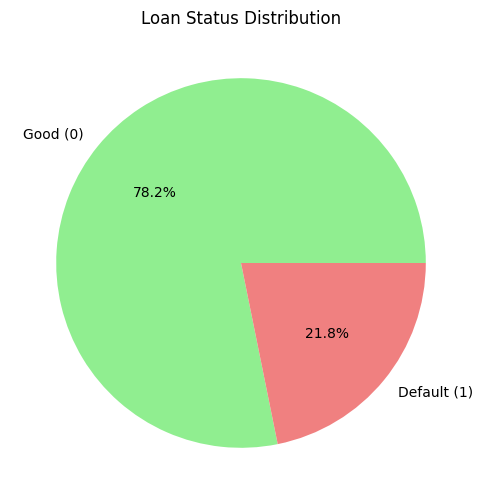

In [7]:
# Analyze target variable distribution
target_dist = df['loan_status'].value_counts()
target_pct = df['loan_status'].value_counts(normalize=True) * 100

print("Target Variable Distribution:")
print(f"Good loans (0): {target_dist[0]:,} ({target_pct[0]:.1f}%)")
print(f"Default loans (1): {target_dist[1]:,} ({target_pct[1]:.1f}%)")
print(f"\nDefault Rate: {target_pct[1]:.1f}%")

# Visualize target distribution
plt.figure(figsize=(8, 6))
colors = ['lightgreen', 'lightcoral']
plt.pie(target_dist.values, labels=['Good (0)', 'Default (1)'], autopct='%1.1f%%', colors=colors)
plt.title('Loan Status Distribution')
plt.show()


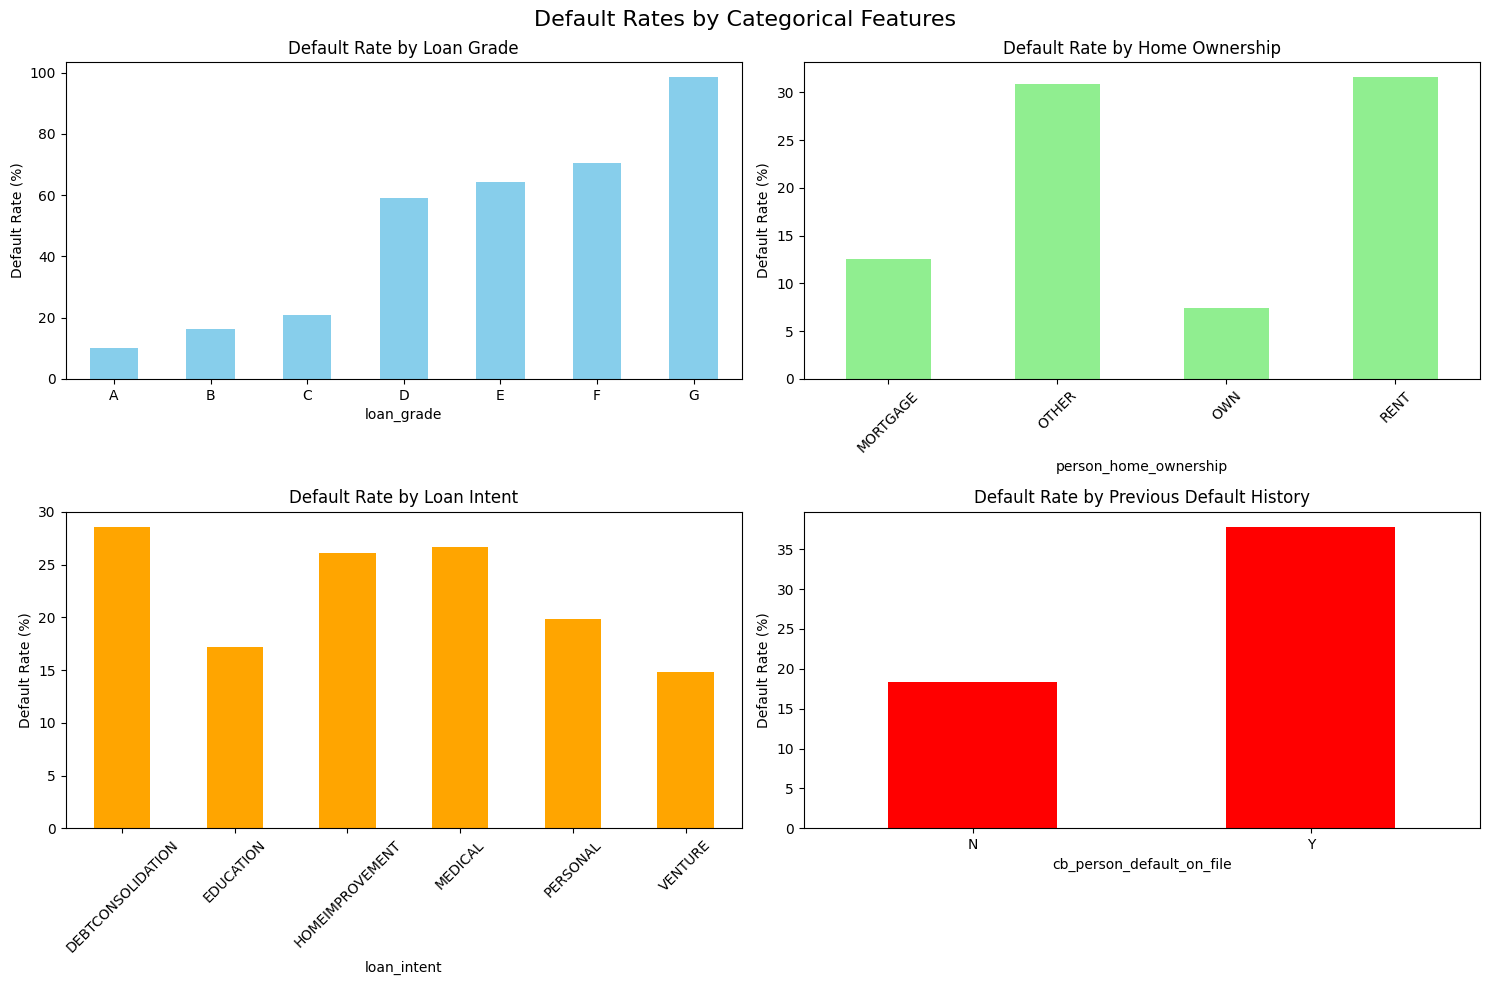

In [8]:
# Analyze default rates by key categorical features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Default Rates by Categorical Features', fontsize=16)

# Default rate by loan grade
grade_default = df.groupby('loan_grade')['loan_status'].mean() * 100
grade_default.plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Default Rate by Loan Grade')
axes[0,0].set_ylabel('Default Rate (%)')
axes[0,0].tick_params(axis='x', rotation=0)

# Default rate by home ownership
home_default = df.groupby('person_home_ownership')['loan_status'].mean() * 100
home_default.plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Default Rate by Home Ownership')
axes[0,1].set_ylabel('Default Rate (%)')
axes[0,1].tick_params(axis='x', rotation=45)

# Default rate by loan intent
intent_default = df.groupby('loan_intent')['loan_status'].mean() * 100
intent_default.plot(kind='bar', ax=axes[1,0], color='orange')
axes[1,0].set_title('Default Rate by Loan Intent')
axes[1,0].set_ylabel('Default Rate (%)')
axes[1,0].tick_params(axis='x', rotation=45)

# Default rate by previous default history
history_default = df.groupby('cb_person_default_on_file')['loan_status'].mean() * 100
history_default.plot(kind='bar', ax=axes[1,1], color='red')
axes[1,1].set_title('Default Rate by Previous Default History')
axes[1,1].set_ylabel('Default Rate (%)')
axes[1,1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


In [9]:
# Create a copy for preprocessing
df_processed = df.copy()

print(f"Original dataset shape: {df_processed.shape}")

# Handle missing values in loan_int_rate
missing_rate_count = df_processed['loan_int_rate'].isnull().sum()
print(f"Missing interest rates: {missing_rate_count} ({missing_rate_count/len(df_processed)*100:.2f}%)")

if missing_rate_count > 0:
    # Fill missing interest rates with median by loan grade
    df_processed['loan_int_rate'] = df_processed.groupby('loan_grade')['loan_int_rate'].transform(
        lambda x: x.fillna(x.median())
    )

    # If still missing, fill with overall median
    df_processed['loan_int_rate'].fillna(df_processed['loan_int_rate'].median(), inplace=True)

    print(f"Missing values after imputation: {df_processed['loan_int_rate'].isnull().sum()}")


Original dataset shape: (32581, 12)
Missing interest rates: 3116 (9.56%)
Missing values after imputation: 0


In [10]:
# Handle outliers and data quality issues
print(f"\nHandling outliers and data quality issues...")
initial_count = len(df_processed)

# Remove unrealistic ages
df_processed = df_processed[(df_processed['person_age'] >= 18) & (df_processed['person_age'] <= 100)]

# Remove unrealistic employment length
df_processed = df_processed[df_processed['person_emp_length'] <= 50]

# Remove unrealistic loan-to-income ratios
df_processed = df_processed[df_processed['loan_percent_income'] <= 1.0]

final_count = len(df_processed)
removed_count = initial_count - final_count
print(f"Removed {removed_count} extreme outliers ({removed_count/initial_count*100:.2f}%)")
print(f"Final dataset shape: {df_processed.shape}")



Handling outliers and data quality issues...
Removed 902 extreme outliers (2.77%)
Final dataset shape: (31679, 12)


In [11]:
# Encode categorical variables
print("Encoding categorical variables...")

# Create label encoders for categorical features
label_encoders = {}
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

for feature in categorical_features:
    le = LabelEncoder()
    df_processed[f'{feature}_encoded'] = le.fit_transform(df_processed[feature])
    label_encoders[feature] = le
    print(f"{feature}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print("\nCategorical encoding completed!")


Encoding categorical variables...
person_home_ownership: {'MORTGAGE': np.int64(0), 'OTHER': np.int64(1), 'OWN': np.int64(2), 'RENT': np.int64(3)}
loan_intent: {'DEBTCONSOLIDATION': np.int64(0), 'EDUCATION': np.int64(1), 'HOMEIMPROVEMENT': np.int64(2), 'MEDICAL': np.int64(3), 'PERSONAL': np.int64(4), 'VENTURE': np.int64(5)}
loan_grade: {'A': np.int64(0), 'B': np.int64(1), 'C': np.int64(2), 'D': np.int64(3), 'E': np.int64(4), 'F': np.int64(5), 'G': np.int64(6)}
cb_person_default_on_file: {'N': np.int64(0), 'Y': np.int64(1)}

Categorical encoding completed!


In [12]:
# Feature engineering
print("Creating additional features...")

# Age groups
df_processed['age_group'] = pd.cut(df_processed['person_age'],
                                  bins=[0, 25, 35, 45, 55, 100],
                                  labels=['18-25', '26-35', '36-45', '46-55', '55+'])
df_processed['age_group_encoded'] = LabelEncoder().fit_transform(df_processed['age_group'])

# Income groups
income_quartiles = df_processed['person_income'].quantile([0, 0.25, 0.5, 0.75, 1.0])
df_processed['income_group'] = pd.cut(df_processed['person_income'],
                                     bins=income_quartiles,
                                     labels=['Low', 'Medium-Low', 'Medium-High', 'High'],
                                     include_lowest=True)
df_processed['income_group_encoded'] = LabelEncoder().fit_transform(df_processed['income_group'])

# Loan-to-income ratio categories
df_processed['lti_category'] = pd.cut(df_processed['loan_percent_income'],
                                     bins=[0, 0.2, 0.4, 0.6, 1.0],
                                     labels=['Low', 'Medium', 'High', 'Very High'])
df_processed['lti_category_encoded'] = LabelEncoder().fit_transform(df_processed['lti_category'])

print("Feature engineering completed!")


Creating additional features...
Feature engineering completed!


In [13]:
# Select features for modeling
feature_columns = [
    'person_age', 'person_income', 'person_emp_length',
    'loan_amnt', 'loan_int_rate', 'loan_percent_income',
    'cb_person_cred_hist_length',
    'person_home_ownership_encoded', 'loan_intent_encoded',
    'loan_grade_encoded', 'cb_person_default_on_file_encoded',
    'age_group_encoded', 'income_group_encoded', 'lti_category_encoded'
]

X = df_processed[feature_columns]
y = df_processed['loan_status']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nSelected features:")
for i, feature in enumerate(feature_columns, 1):
    print(f"{i:2d}. {feature}")


Feature matrix shape: (31679, 14)
Target vector shape: (31679,)

Selected features:
 1. person_age
 2. person_income
 3. person_emp_length
 4. loan_amnt
 5. loan_int_rate
 6. loan_percent_income
 7. cb_person_cred_hist_length
 8. person_home_ownership_encoded
 9. loan_intent_encoded
10. loan_grade_encoded
11. cb_person_default_on_file_encoded
12. age_group_encoded
13. income_group_encoded
14. lti_category_encoded


In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts(normalize=True) * 100)
print(f"\nTest set class distribution:")
print(y_test.value_counts(normalize=True) * 100)


Training set shape: (25343, 14)
Test set shape: (6336, 14)

Training set class distribution:
loan_status
0    78.455589
1    21.544411
Name: proportion, dtype: float64

Test set class distribution:
loan_status
0    78.456439
1    21.543561
Name: proportion, dtype: float64


In [15]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")
print(f"Feature means after scaling: {X_train_scaled.mean(axis=0).round(3)}")
print(f"Feature stds after scaling: {X_train_scaled.std(axis=0).round(3)}")


Features scaled successfully!
Feature means after scaling: [-0.  0. -0.  0. -0.  0.  0. -0. -0.  0. -0.  0.  0.  0.]
Feature stds after scaling: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [17]:
# Build baseline logistic regression model


lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
lr_baseline.fit(X_train_scaled, y_train)

# Make predictions
y_pred_baseline = lr_baseline.predict(X_test_scaled)
y_pred_proba_baseline = lr_baseline.predict_proba(X_test_scaled)[:, 1]




In [18]:
# Hyperparameter tuning with GridSearch
print("Performing hyperparameter tuning...")

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

lr_grid = LogisticRegression(random_state=42, max_iter=1000)
grid_search = GridSearchCV(
    lr_grid, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
lr_best = grid_search.best_estimator_
y_pred_best = lr_best.predict(X_test_scaled)
y_pred_proba_best = lr_best.predict_proba(X_test_scaled)[:, 1]


Performing hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.8501


In [19]:
# Evaluation function
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    print(f"\n{'='*50}")
    print(f"{model_name} EVALUATION")
    print(f"{'='*50}")

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    return {
        'accuracy': accuracy, 'precision': precision, 'recall': recall,
        'f1': f1, 'roc_auc': roc_auc
    }

# Evaluate both models
baseline_metrics = evaluate_model(y_test, y_pred_baseline, y_pred_proba_baseline, "BASELINE LOGISTIC REGRESSION")
best_metrics = evaluate_model(y_test, y_pred_best, y_pred_proba_best, "TUNED LOGISTIC REGRESSION")



BASELINE LOGISTIC REGRESSION EVALUATION
Accuracy:  0.8497
Precision: 0.7333
Recall:    0.4755
F1-Score:  0.5769
ROC-AUC:   0.8561

TUNED LOGISTIC REGRESSION EVALUATION
Accuracy:  0.8497
Precision: 0.7344
Recall:    0.4740
F1-Score:  0.5761
ROC-AUC:   0.8562


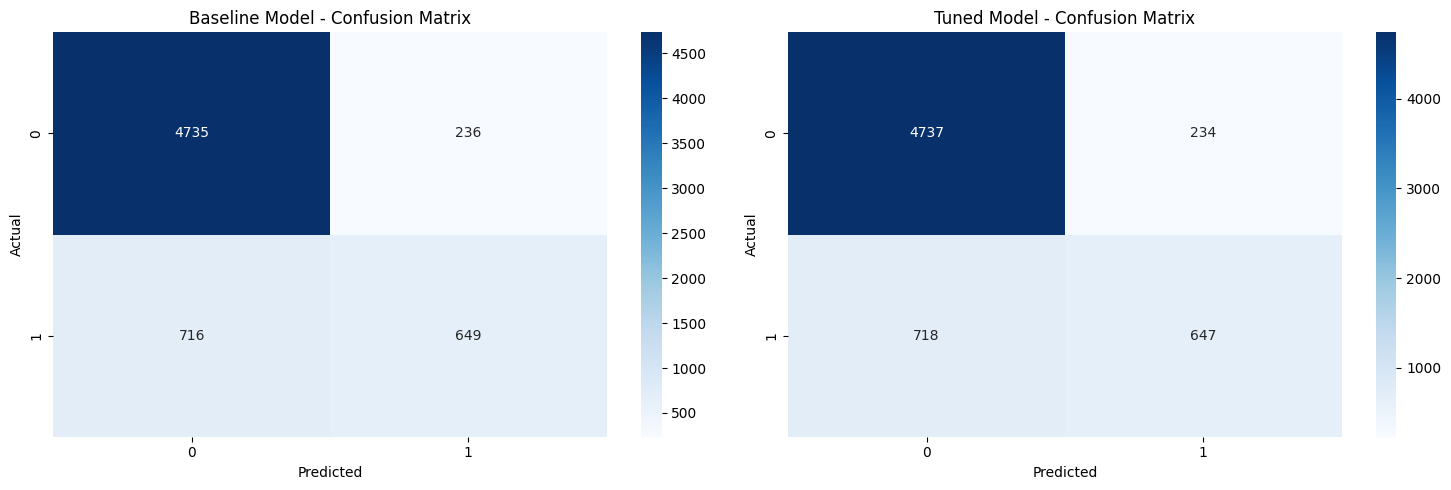

In [20]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Baseline model confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Baseline Model - Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Best model confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Tuned Model - Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


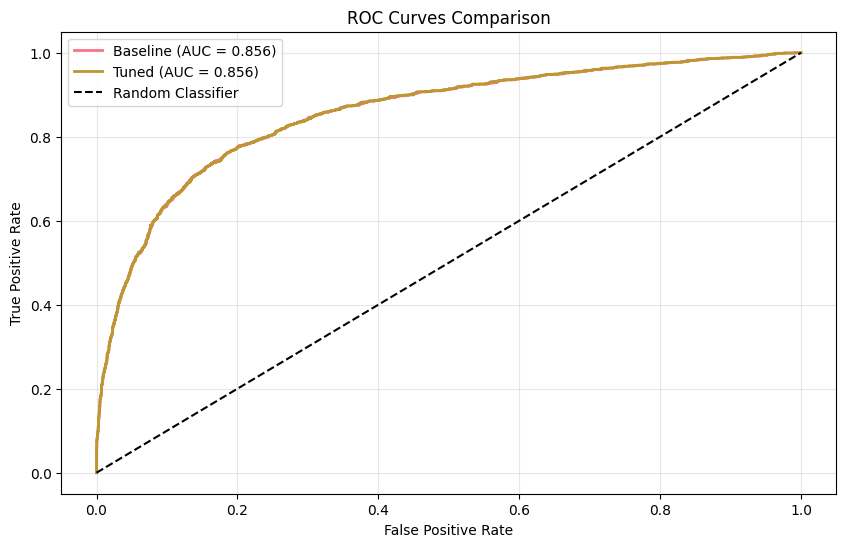

In [21]:
# ROC Curves
plt.figure(figsize=(10, 6))

# Baseline model ROC
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC = {baseline_metrics["roc_auc"]:.3f})', linewidth=2)

# Best model ROC
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)
plt.plot(fpr_best, tpr_best, label=f'Tuned (AUC = {best_metrics["roc_auc"]:.3f})', linewidth=2)

# Random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [22]:
# Detailed classification report
print("\nDETAILED CLASSIFICATION REPORT - TUNED MODEL")
print("="*60)
print(classification_report(y_test, y_pred_best, target_names=['Good Loan', 'Default']))



DETAILED CLASSIFICATION REPORT - TUNED MODEL
              precision    recall  f1-score   support

   Good Loan       0.87      0.95      0.91      4971
     Default       0.73      0.47      0.58      1365

    accuracy                           0.85      6336
   macro avg       0.80      0.71      0.74      6336
weighted avg       0.84      0.85      0.84      6336



In [23]:
# Feature importance from logistic regression coefficients
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': lr_best.coef_[0],
    'abs_coefficient': np.abs(lr_best.coef_[0])
})

feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print("FEATURE IMPORTANCE (Logistic Regression Coefficients)")
print("="*60)
print(feature_importance[['feature', 'coefficient']].to_string(index=False))


FEATURE IMPORTANCE (Logistic Regression Coefficients)
                          feature  coefficient
              loan_percent_income     1.240767
               loan_grade_encoded     1.134663
                        loan_amnt    -0.482038
    person_home_ownership_encoded     0.378918
              loan_intent_encoded    -0.228142
             income_group_encoded    -0.149798
                    loan_int_rate    -0.119132
             lti_category_encoded    -0.092750
cb_person_default_on_file_encoded    -0.037255
                person_emp_length    -0.032728
                    person_income    -0.014850
                       person_age     0.002973
       cb_person_cred_hist_length     0.000000
                age_group_encoded     0.000000


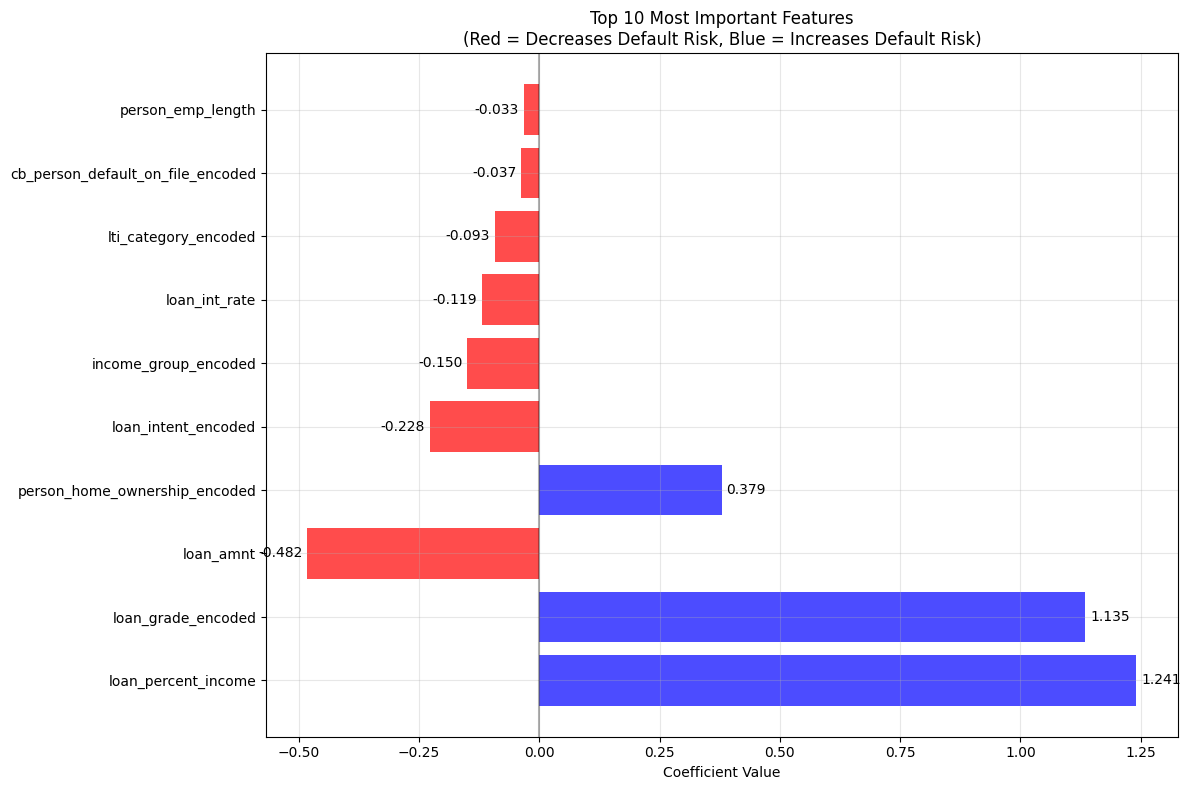

In [24]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)

colors = ['red' if coef < 0 else 'blue' for coef in top_features['coefficient']]
bars = plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)

plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Most Important Features\n(Red = Decreases Default Risk, Blue = Increases Default Risk)')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top_features['coefficient'])):
    plt.text(value + (0.01 if value >= 0 else -0.01), i, f'{value:.3f}',
             ha='left' if value >= 0 else 'right', va='center')

plt.tight_layout()
plt.show()


In [25]:
# Analyze prediction probabilities
probability_analysis = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred_best,
    'probability': y_pred_proba_best
})

# Risk categories based on probability
probability_analysis['risk_category'] = pd.cut(
    probability_analysis['probability'],
    bins=[0, 0.3, 0.7, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

print("RISK CATEGORY ANALYSIS")
print("="*30)
risk_summary = probability_analysis.groupby('risk_category').agg({
    'actual': ['count', 'sum', 'mean'],
    'probability': ['min', 'max', 'mean']
})

risk_summary.columns = ['Count', 'Actual_Defaults', 'Default_Rate', 'Min_Prob', 'Max_Prob', 'Avg_Prob']
risk_summary['Default_Rate'] = risk_summary['Default_Rate'] * 100
print(risk_summary.round(3))


RISK CATEGORY ANALYSIS
               Count  Actual_Defaults  Default_Rate  Min_Prob  Max_Prob  \
risk_category                                                             
Low Risk        4720              415         8.792     0.003     0.300   
Medium Risk     1203              602        50.042     0.300     0.700   
High Risk        413              348        84.262     0.701     0.998   

               Avg_Prob  
risk_category            
Low Risk          0.098  
Medium Risk       0.467  
High Risk         0.833  


In [26]:
# Model interpretation and key insights
print("\nKEY MODEL INSIGHTS AND RECOMMENDATIONS")
print("="*50)

print("\n🔍 TOP RISK FACTORS (Increase Default Probability):")
risk_factors = feature_importance[feature_importance['coefficient'] > 0].head(5)
for idx, row in risk_factors.iterrows():
    print(f"• {row['feature']}: {row['coefficient']:.3f}")

print("\n✅ TOP PROTECTIVE FACTORS (Decrease Default Probability):")
protective_factors = feature_importance[feature_importance['coefficient'] < 0].head(5)
for idx, row in protective_factors.iterrows():
    print(f"• {row['feature']}: {row['coefficient']:.3f}")

print("\n💡 BUSINESS RECOMMENDATIONS:")
print("• Focus on loan grade assessment - it's a strong predictor")
print("• Consider loan-to-income ratio limits for risk management")
print("• Previous default history is a critical factor - weight accordingly")
print("• Interest rates should reflect the risk profile accurately")
print("• Age and employment length provide additional risk signals")

print(f"\n📊 MODEL PERFORMANCE SUMMARY:")
print(f"• ROC-AUC: {best_metrics['roc_auc']:.3f} - Model has good discriminative ability")
print(f"• Precision: {best_metrics['precision']:.3f} - {best_metrics['precision']*100:.1f}% of predicted defaults are actual defaults")
print(f"• Recall: {best_metrics['recall']:.3f} - Model catches {best_metrics['recall']*100:.1f}% of actual defaults")
print(f"• F1-Score: {best_metrics['f1']:.3f} - Balanced performance metric")



KEY MODEL INSIGHTS AND RECOMMENDATIONS

🔍 TOP RISK FACTORS (Increase Default Probability):
• loan_percent_income: 1.241
• loan_grade_encoded: 1.135
• person_home_ownership_encoded: 0.379
• person_age: 0.003

✅ TOP PROTECTIVE FACTORS (Decrease Default Probability):
• loan_amnt: -0.482
• loan_intent_encoded: -0.228
• income_group_encoded: -0.150
• loan_int_rate: -0.119
• lti_category_encoded: -0.093

💡 BUSINESS RECOMMENDATIONS:
• Focus on loan grade assessment - it's a strong predictor
• Consider loan-to-income ratio limits for risk management
• Previous default history is a critical factor - weight accordingly
• Interest rates should reflect the risk profile accurately
• Age and employment length provide additional risk signals

📊 MODEL PERFORMANCE SUMMARY:
• ROC-AUC: 0.856 - Model has good discriminative ability
• Precision: 0.734 - 73.4% of predicted defaults are actual defaults
• Recall: 0.474 - Model catches 47.4% of actual defaults
• F1-Score: 0.576 - Balanced performance metric


In [27]:
# Save the model and preprocessing objects
import joblib

# Save the trained model and preprocessing objects
joblib.dump(lr_best, 'credit_default_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

print("\nModel and preprocessing objects saved successfully!")
print("Files created:")
print("• credit_default_model.pkl - Trained logistic regression model")
print("• feature_scaler.pkl - Feature scaling object")
print("• label_encoders.pkl - Categorical encoding objects")



Model and preprocessing objects saved successfully!
Files created:
• credit_default_model.pkl - Trained logistic regression model
• feature_scaler.pkl - Feature scaling object
• label_encoders.pkl - Categorical encoding objects
